In [1]:
!rm watsoniotp.*
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
!wget https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle

rm: cannot remove 'watsoniotp.*': No such file or directory
--2020-08-26 20:18:41--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.healthy.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 194639 (190K) [text/plain]
Saving to: ‘watsoniotp.healthy.phase_aligned.pickle’

watsoniotp.healthy. 100%[===================>] 190.08K  --.-KB/s    in 0.03s   

2020-08-26 20:18:42 (6.90 MB/s) - ‘watsoniotp.healthy.phase_aligned.pickle’ saved [194639/194639]

--2020-08-26 20:18:42--  https://raw.githubusercontent.com/romeokienzler/developerWorks/master/lorenzattractor/watsoniotp.broken.phase_aligned.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.1

In [2]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from  sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from queue import Queue
%matplotlib inline

In [3]:
data_healthy = pickle.load(open('watsoniotp.healthy.phase_aligned.pickle', 'rb'), encoding="latin1")
data_broken = pickle.load(open('watsoniotp.broken.phase_aligned.pickle', 'rb'), encoding="latin1")

In [4]:
data_healthy = data_healthy.reshape(3000,3)
data_broken = data_broken.reshape(3000,3)

In [5]:
data_broken.shape

(3000, 3)

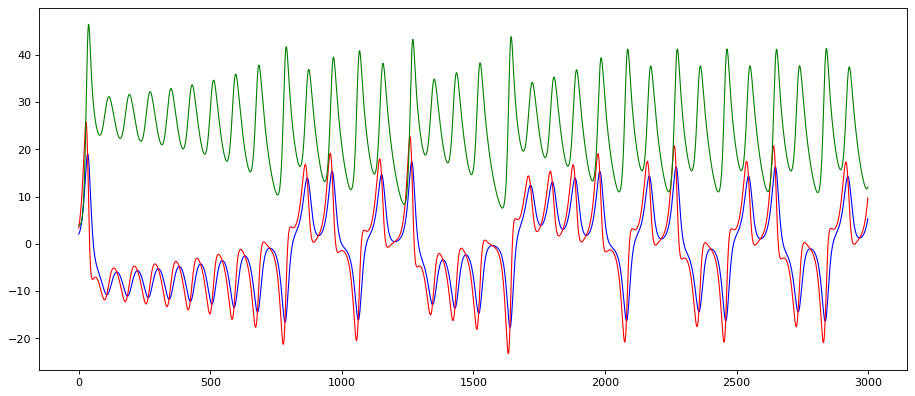

In [6]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy)
#ax.set_ylim(0,energy.max())
ax.plot(range(0,size), data_healthy[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy[:,2], '-', color='green', animated = True, linewidth=1)


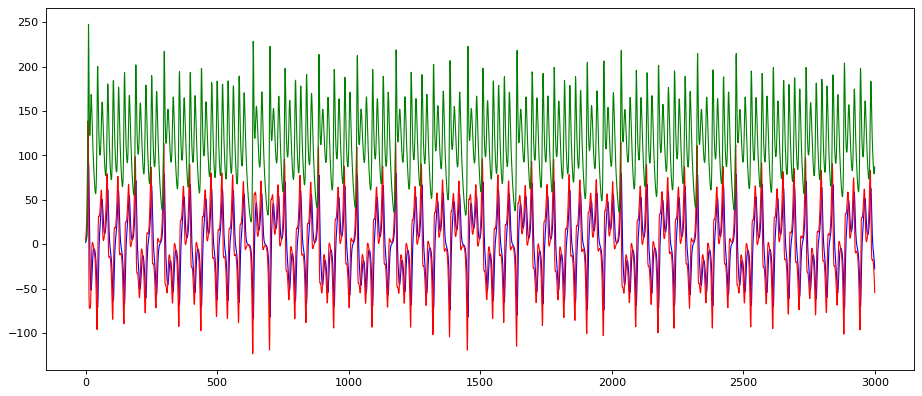

In [10]:
size = len(data_broken)
#ax.set_ylim(0,energy.max())
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,size), data_broken[:,0], '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken[:,2], '-', color='green', animated = True, linewidth=1)


In [11]:

data_healthy_fft = np.fft.fft(data_healthy)
data_broken_fft = np.fft.fft(data_broken)

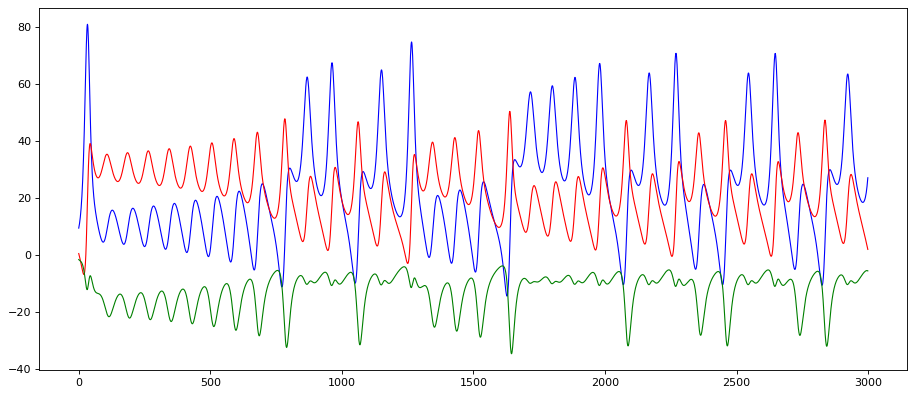

In [12]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_healthy_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_healthy_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

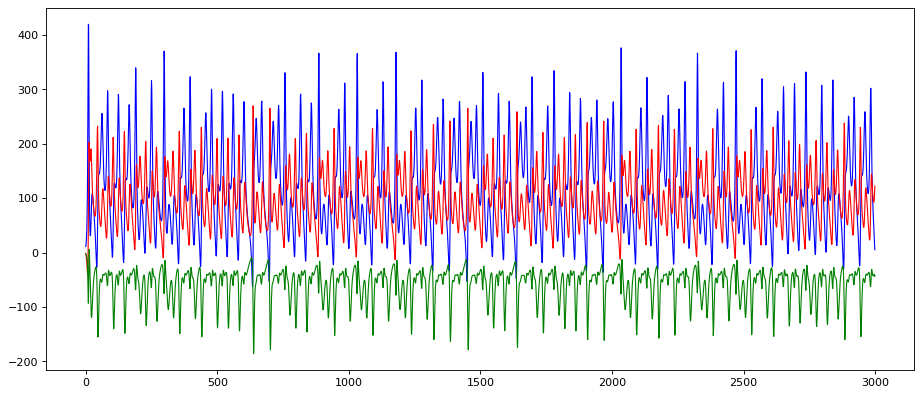

In [13]:

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(data_healthy_fft)
ax.plot(range(0,size), data_broken_fft[:,0].real, '-', color='blue', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,1].imag, '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), data_broken_fft[:,2].real, '-', color='green', animated = True, linewidth=1)

In [15]:
def scaleData(data):
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data)

In [16]:
data_healthy_scaled = scaleData(data_healthy)
data_broken_scaled = scaleData(data_broken)

In [17]:
timesteps = 10
dim = 3
samples = 3000
data_healthy_scaled_reshaped = data_healthy_scaled
data_healthy_scaled_reshaped.shape = (int(samples/timesteps),timesteps,dim)

In [18]:
losses = []

def handleLoss(loss):
        global losses
        losses+=[loss]
        print(loss)

In [21]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        handleLoss(logs.get('loss'))

In [19]:
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(10,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(3,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(10,input_shape=(timesteps,dim),return_sequences=True))
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(3))
model.compile(loss='mae', optimizer='adam')

def train(data):
    data.shape = (300, 10, 3)
    model.fit(data, data, epochs=50, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[LossHistory()])
    data.shape = (3000, 3)

def score(data):
    data.shape = (300, 10, 3)
    yhat =  model.predict(data)
    yhat.shape = (3000, 3)
    return yhat

In [24]:
for i in range(20):
    
    print("----------------")
    train(data_healthy_scaled)
    yhat_healthy = score(data_healthy_scaled)
    yhat_broken = score(data_broken_scaled)
    data_healthy_scaled.shape = (3000, 3)
    data_broken_scaled.shape = (3000, 3)


print ("----------------broken")
train(data_broken_scaled)
yhat_healthy = score(data_healthy_scaled)
yhat_broken = score(data_broken_scaled)
data_healthy_scaled.shape = (3000, 3)
data_broken_scaled.shape = (3000, 3)

Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 0s 28ms/step - loss: 0.0195 - val_loss: 0.0207
Epoch 39/50
0.02106737531721592
1/5 [=====>........................] - ETA: 0s - loss: 0.02110.020485788583755493
0.01950058899819851
3/5 [=================>............] - ETA: 0s - loss: 0.01950.01926964893937111
0.019143814221024513
5/5 [==============================] - 0s 30ms/step - loss: 0.0191 - val_loss: 0.0165
Epoch 40/50
0.016166845336556435
1/5 [=====>........................] - ETA: 0s - loss: 0.01620.017310278490185738
0.017680585384368896
0.01753915101289749
5/5 [==============================] - 0s 28ms/step - loss: 0.0174 - val_loss: 0.0171
Epoch 41/50
0.017162328585982323
1/5 [=====>........................] - ETA: 0s - loss: 0.01720.01763819344341755
0.01722755655646324
0.017605062574148178
5/5 [==============================] - 0s 27ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 42/50
0.015059888362884521
1/5 [=====>..............

In [ ]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,len(losses)), losses, '-', color='blue', animated = True, linewidth=1)